# June 28, 2022: ROI ordering
cleverly order rois to ease finding patterns in Inter-Subject (Functional) Correlation (IS(F)C) matrices.

NOT FOCUSSING ON THIS (JULY 15). SEE THE IPYNB IN JULY.
 
INSTEAD WE ARE SELECTING A SUBSET OF ROIS (DISCUSSED WITH LUIZ ON HUDDLE) AND ANALYZING THE TIME SERIES.

In [1]:
import os
import sys
from os.path import join as pjoin

import numpy as np
import pandas as pd
import pickle, random
from tqdm import tqdm
from scipy.stats import zscore

# plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParamsDefault['font.family'] = "sans-serif"
plt.rcParamsDefault['font.sans-serif'] = "Arial"
plt.rcParams['font.size'] = 14
plt.rcParams["errorbar.capsize"] = 0.5

# main dirs
proj_dir = pjoin(os.environ['HOME'], 'network_dynamics')
results_dir = f"{proj_dir}/results"
month_dir = f"{proj_dir}/nb/jun22"

# folders
sys.path.insert(0, proj_dir)
import helpers.dataset_utils as dataset_utils
 

In [2]:
'''
exploratory data
'''
class ARGS(): pass
args = ARGS()

args.SEED = 74
args.LABELS = [0, 1]
args.names = ['safe', 'threat']
args.MASK = -100

num_rois = 85
args.roi_idxs = np.arange(num_rois)

# time series
with open(f"{proj_dir}/data/max/exploratory_data.pkl", 'rb') as f:
    X = pickle.load(f)

In [3]:
# for threat condition
# mean time series across trials and subjects
for label in args.LABELS[1:]:
    ts = []
    for idx_subj in np.arange(len(X[label])):
        ts.append(zscore(X[label][idx_subj], axis=-1))

    ts = np.concatenate(ts, axis=0)
    ts_mean = np.mean(np.mean(ts, axis=0), axis=0)

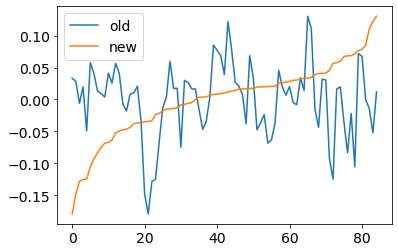

In [4]:
plt.plot(ts_mean, label='old')
roi_idxs = np.argsort(ts_mean)
plt.plot(ts_mean[roi_idxs], label='new')
plt.legend()

In [5]:
with open(f"{proj_dir}/data/max/exploratory_data_roi_indices.pkl", 'wb') as f:
    pickle.dump(roi_idxs, f)

In [6]:
roi_names = pd.read_csv(
    '/home/govindas/parcellations/MAX_85_ROI_masks/ROI_names.txt',
    header=None,
)[0].values

roi_names

array(['R med. OFC', 'L med. OFC', 'R lat. OFC', 'L lat. OFC', 'M vmPFC1',
       'M vmPFC2', 'R dlPFC', 'L dlPFC', 'R FEF', 'L FEF',
       'R pregenual ACC', 'L pregenual ACC', 'R ACC', 'L ACC',
       'R ant. MCC', 'L ant. MCC', 'R post. MCC', 'L post. MCC',
       'R pre-SMA', 'L pre-SMA', 'M PCC', 'R PCC/precuneus',
       'L PCC/precuneus', 'R PCC', 'L PCC', 'R Ventral striatum',
       'L Ventral striatum', 'R ant. Putamen', 'L ant. Putamen',
       'R post. Putamen', 'L post. Putamen', 'R ant. Caudate',
       'L ant. Caudate', 'R post. Caudate', 'L post. Caudate', 'R IFG-1',
       'L IFG-1', 'R IFG-2', 'L IFG-2', 'R IFG-3', 'L IFG-3', 'R IFG-4',
       'L IFG-4', 'R IFG-5', 'L IFG-5', 'R IFG-6', 'L IFG-6',
       'R ant. ventral Insula', 'L ant. ventral Insula',
       'R ant. dorsal Insula', 'L ant. dorsal Insula',
       'R mid/post Insula', 'L mid/post Insula', 'R BST', 'L BST',
       'R CeMe Amygdala', 'L CeMe Amygdala', 'R BLBM Amygdala',
       'L BLBM Amygdala', 'R an

In [7]:
ts.shape

(417, 14, 85)

## ROI time series

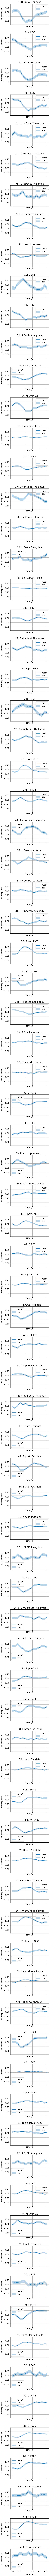

In [8]:
nrows, ncols = 85, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 4*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.45
)

ts_mn = np.mean(ts, axis=0)
ts_st = np.std(ts, axis=0) / np.sqrt(ts.shape[0])

for idx_roi in np.arange(len(roi_names)):
    ax = axs[idx_roi]

    mn = ts_mn[:, roi_idxs[idx_roi]]
    st = ts_st[:, roi_idxs[idx_roi]]

    ax.plot(mn, label='mean')
    ax.fill_between(
        np.arange(st.shape[0]),
        (mn - st), (mn + st),
        label='ste',
        alpha=0.3
    )
    
    ax.legend()
    ax.set_title(f"{idx_roi+1}: {roi_names[roi_idxs[idx_roi]]}")
    ax.set_ylabel(f"roi response")
    ax.set_xlabel(f"time (s)")
    ax.grid(True)

## Mean response across time

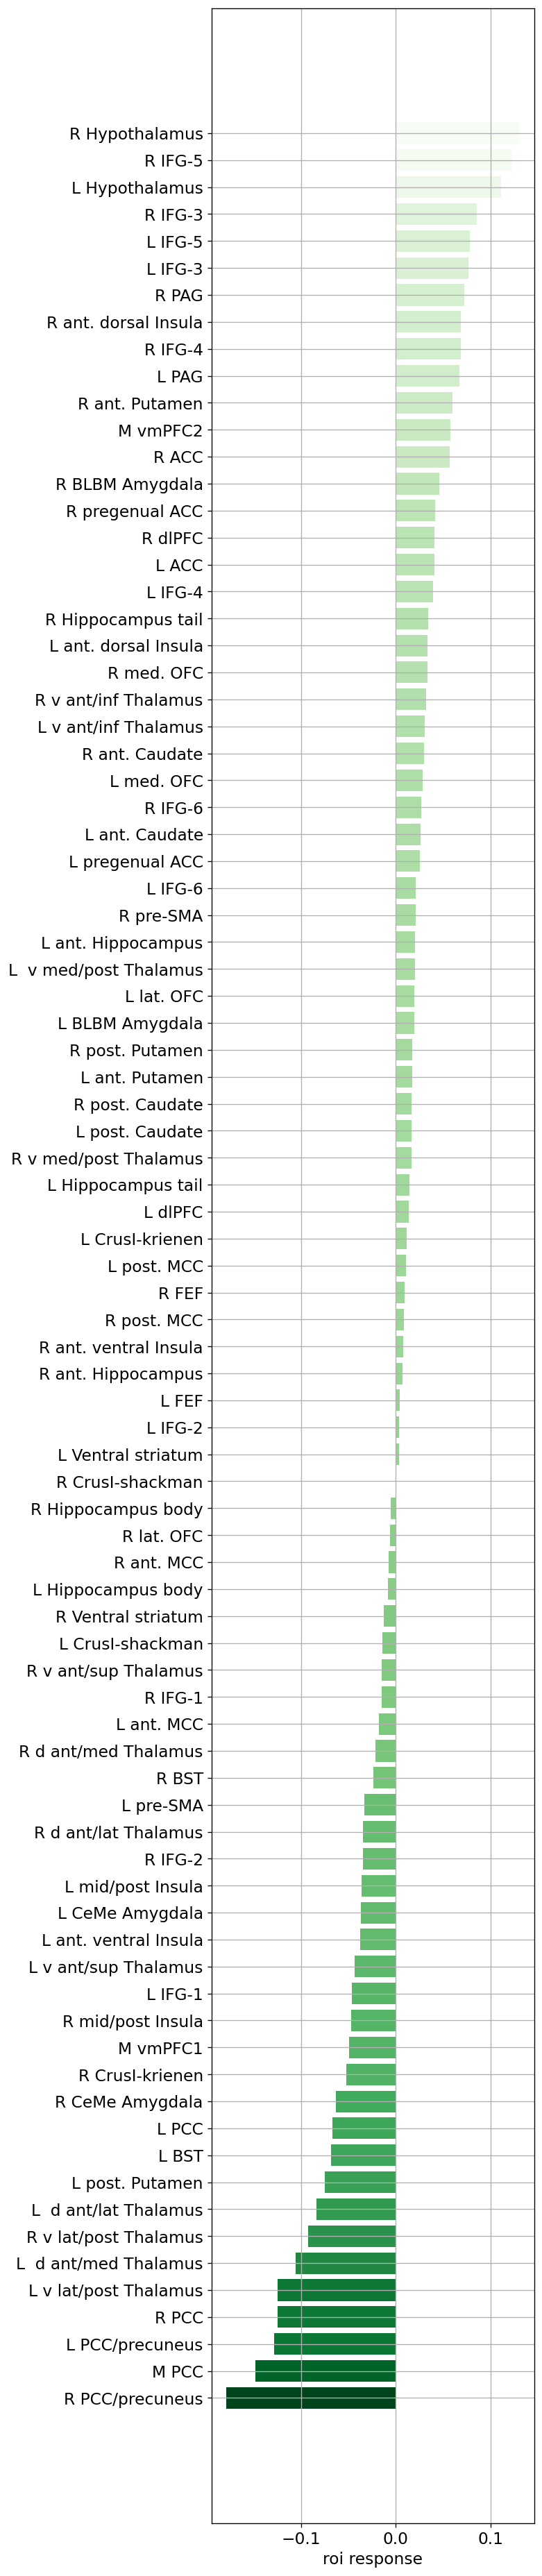

In [9]:
nrows, ncols = 1, 1
fig, axs = plt.subplots(
    nrows=nrows, 
    ncols=ncols, 
    figsize=(5*ncols, 40*nrows), 
    sharex=True, 
    sharey=True, 
    dpi=120
)

plt.subplots_adjust(
    left=None, bottom=None, 
    right=None, top=None, 
    wspace=None, hspace=0.45
)

rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))

ax = axs
x_pts = ts_mean[roi_idxs]
ypos = np.arange(ts_mean.shape[0])
cmap = 'Greens_r'
ax.barh(
    y=ypos, 
    width=x_pts, 
    color=mpl.colormaps[cmap](rescale(x_pts))
)
ax.set_xlabel(f"roi response")
ax.set_yticks(ypos, labels=roi_names[roi_idxs])
ax.grid(True)

## Graph clustering based on Functional Connectivity